In [2]:
import keras
print(keras.__version__)

import tensorflow
print(tensorflow.__version__)

2.6.0
2.6.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications.efficientnet import EfficientNetB0, preprocess_input, decode_predictions
import numpy as np
import os
import cv2 

In [5]:
from scipy.ndimage.interpolation import zoom
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from keras.preprocessing.image import load_img, img_to_array

In [6]:
tf.compat.v1.disable_eager_execution()

In [17]:
def grad_cam(input_model, image, layer_name,H=224,W=224):
    cls = np.argmax(input_model.predict(image))
    #print("class = ",cls)
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    output, grads_val = output[0, :], grads_val[0, :, :, :]

    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)
    cam = zoom(cam,H/cam.shape[0])
    cam = cam / cam.max()
    return cam

In [8]:
model = EfficientNetB0(include_top=True, weights='imagenet',input_shape=(224,224,3))

Instructions for updating:
Colocations handled automatically by placer.
21848064/21834768 [==============================] - 1s 0us/step


In [9]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [34]:
paths = ["3dshop_L104287.jpg","freeFoto_16_06_10_prev.jpg","pggan_chair (69).png"]

<Figure size 1296x1080 with 0 Axes>

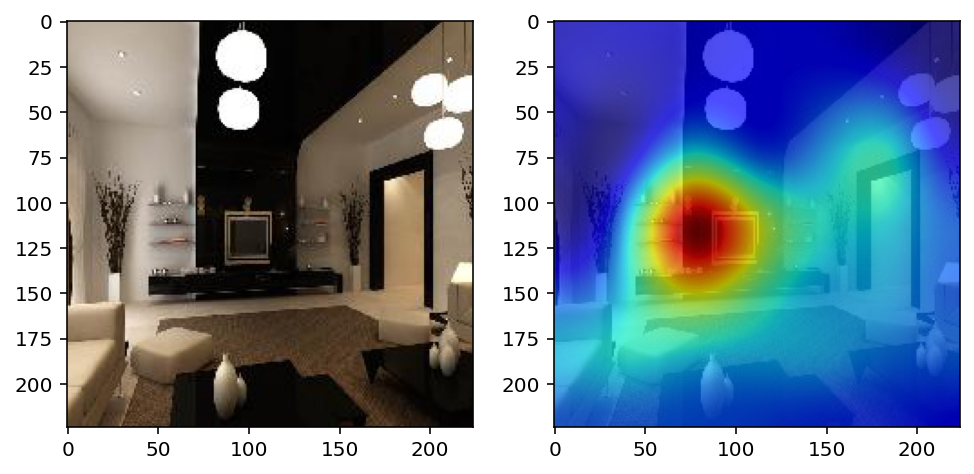

<Figure size 1296x1080 with 0 Axes>

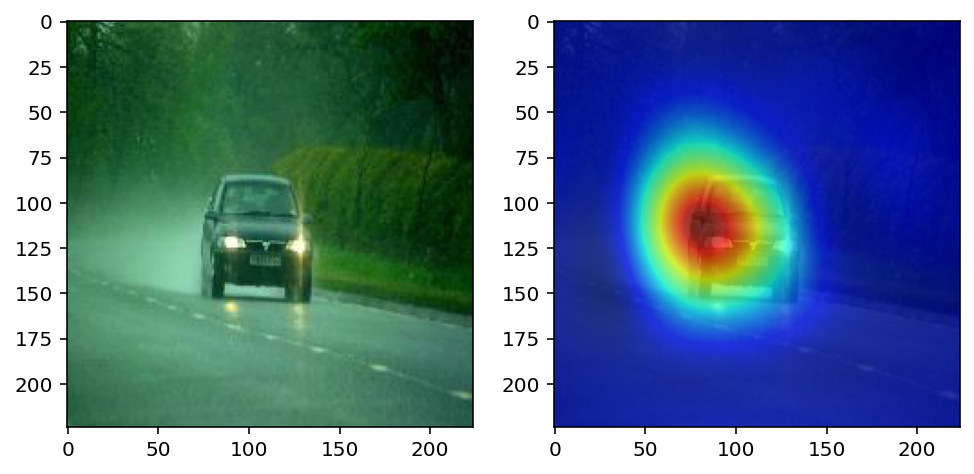

<Figure size 1296x1080 with 0 Axes>

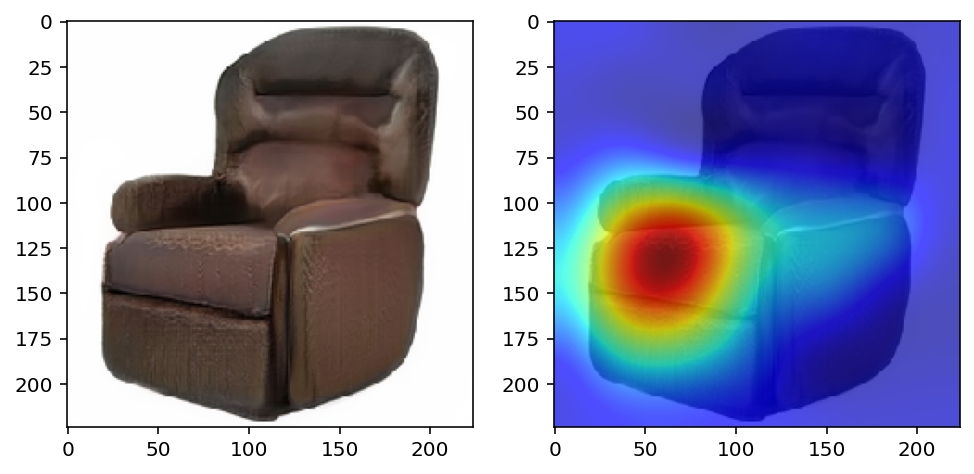

In [38]:
for path in paths:

    path = os.path.join("/content/drive/MyDrive/gradcam/data_for_eff_imagenet/1",path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = model.predict(img)
    gradcam = grad_cam(model,img,layer_name='top_activation')
    plt.figure(figsize=(18, 15))
    fig, ax = plt.subplots(nrows=1,ncols=2)
    plt.subplot(121)
    plt.imshow(orig_img)
    plt.subplot(122)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.7,cmap="jet")
